In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
from random import randint

import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import time

c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# HW5

For this homework, we are going to use [CELEB-A dataset](https://www.tensorflow.org/datasets/catalog/celeb_a). CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including - 10,177 number of identities, - 202,599 number of face images, and - 5 landmark locations, 40 binary attributes annotations per image.

Follow the step-by-step instructions below to dowload data.

## Downloading the CELEB-A Dataset 

In this section, I will guide you to manually fetch and install the CELEB-A dataset so that TensorFlow Datasets (TFDS) can load it properly for this homework.


### Step 1: Create a Local Dataset Directory

Choose a directory on your machine to store TensorFlow datasets (replace with your preferred path). We will refer to this path as your `DATA_DIR`. For me the setup is like below, but you should change it for your setup accordingly. If the directory does not exist, create it.

In [2]:
# WRITE THE LOCATION OF THE DATA DIRECTORY
DATA_DIR = r"C:\Class\MYZ309E\HW5\data\tensorflow_datasets"

### Step 2: Manually Download the Dataset

TensorFlow cannot automatically fetch CELEB-A due to Google Drive download restrictions. Follow these steps:

1. Open the official download link in a browser:

   [https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view](https://drive.google.com/file/d/0B7EVK8r0v71pZjFTYXZWM3FlRnM/view)

   Click the **"Download anyway"** button (you may need to wait or confirm warnings about large files).

2. This will download a file named: `img_align_celeba.zip`

3. After download completes, **create a subdirectory** called `downloads/manual` and **move the file into the manual data directory**. In my case this is "/home/kaygun/local/data/tensorflow_datasets/dowloads/manual/".

### Step 3: Prepare the Dataset with TensorFlow Datasets

Once the file is in place, use the following Python code to prepare the dataset:

In [3]:
# Initialize and prepare the dataset builder
builder = tfds.builder('celeb_a', data_dir=DATA_DIR)

builder.download_and_prepare(download_config=tfds.download.DownloadConfig(
    manual_dir=f"{DATA_DIR}/downloads/manual",
    download_mode=tfds.download.GenerateMode.REUSE_CACHE_IF_EXISTS
))

Dl Size...: 0 MiB [00:00, ? MiB/s]5/5 [00:00<00:00, 97.13 url/s] 
Dl Completed...: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5/5 [00:00<00:00, 79.52 url/s]


FileExistsError: Cannot rename C:\Class\MYZ309E\HW5\data\tensorflow_datasets\celeb_a\2.1.0.incompleteZOO7F5. Destination C:\Class\MYZ309E\HW5\data\tensorflow_datasets\celeb_a\2.1.0 already exists.

After this step, the dataset will be extracted, validated, and cached in a format that can be loaded.

### Notes

- The CELEB-A dataset is ~1.3 GB. Make sure you have enough disk space.
- Do **not unzip** the archive. TFDS expects the raw `.zip` file.
- The dataset will only need to be downloaded once; subsequent runs will use the cached version.

## Ingesting the Dataset into Our Environment

Now, let us load up the data:


In [4]:
train_ds, val_ds, test_ds = tfds.load(
    'celeb_a',
    split=['train', 'validation', 'test'],
    data_dir=DATA_DIR,
    as_supervised=False
)

I'll take 10 random examples from the training set.

In [5]:
N = 500
examples = list(train_ds.take(N))

Now, let us display a random image together with the metadata attached (here called 'attributes') to the picture:

{'5_o_Clock_Shadow': <tf.Tensor: shape=(), dtype=bool, numpy=True>,
 'Arched_Eyebrows': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Attractive': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Bags_Under_Eyes': <tf.Tensor: shape=(), dtype=bool, numpy=True>,
 'Bald': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Bangs': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Big_Lips': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Big_Nose': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Black_Hair': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Blond_Hair': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Blurry': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Brown_Hair': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Bushy_Eyebrows': <tf.Tensor: shape=(), dtype=bool, numpy=True>,
 'Chubby': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Double_Chin': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Eyeglasses': <tf.Tensor: shape=(), dtype=bool, numpy=False

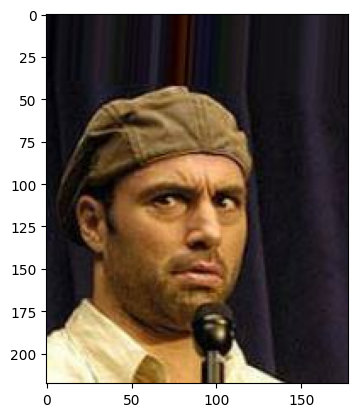

In [6]:
example = examples[randint(0,N)]
plt.imshow(example['image'])
example['attributes']

Here is another example with its attributes:

{'5_o_Clock_Shadow': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Arched_Eyebrows': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Attractive': <tf.Tensor: shape=(), dtype=bool, numpy=True>,
 'Bags_Under_Eyes': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Bald': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Bangs': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Big_Lips': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Big_Nose': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Black_Hair': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Blond_Hair': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Blurry': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Brown_Hair': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Bushy_Eyebrows': <tf.Tensor: shape=(), dtype=bool, numpy=True>,
 'Chubby': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Double_Chin': <tf.Tensor: shape=(), dtype=bool, numpy=False>,
 'Eyeglasses': <tf.Tensor: shape=(), dtype=bool, numpy=Fals

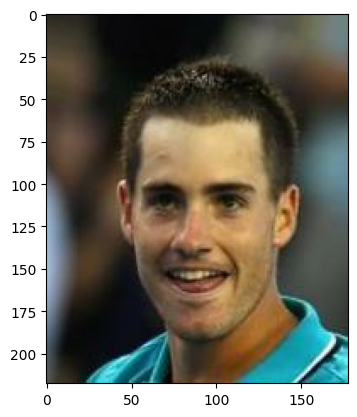

In [7]:
example = examples[randint(0,N)]
plt.imshow(example['image'])
example['attributes']

# Questions

In the questions below, you will construct and evaluate several classification models based on the CELEB-A dataset. Your goal is not only to develop accurate classifiers, but also to critically assess and compare the models through rigorous validation and analysis.

As before follow the rules stated below:

- Do not split your answers into separate files. All answers must be in a single jupyter notebook.
- Follow the step-by-step instructions provided at the beginning of this document to download and prepare the CELEB-A dataset using `tensorflow_datasets`. **DO NOT PUSH YOUR LOCAL COPY OF THE DATASET TO YOUR REPO**!!
- Refrain from using code comments to explain what has been done. Document your steps by writing appropriate markdown cells in your notebook.
- Avoid duplicating code by copying and pasting it from one cell to another. If copying and pasting is necessary, develop a suitable function for the task at hand and call that function.
- When providing parameters to a function, never use global variables. Instead, always pass parameters explicitly and always make use of local variables.
- Document your use of LLM models (ChatGPT, Claude, Code Pilot etc). You may
   + provide working links to your logs
   + take screenshots of your steps and include them with this notebook, or
   + give me a full log (both questions and answers) in a markdown file named HW5-LLM-LOG.md.

Failure to adhere to these guidelines will result in a 15-point deduction for each infraction.


## Q1 ‚Äî Linear Models for Gender Classification

1. Train a **Support Vector Machine (SVM)** and a **Logistic Regression** model to classify the **gender** of the person in the image.
2. Evaluate both models using a rigorous **cross-validation scheme** and present a comprehensive **error analysis**.
3. **Select and justify** the model you believe is better suited to the task, both in terms of accuracy, precision, recall, and computational considerations.

In [29]:
def preprocess_image(example, image_size=(64, 64)):
    """CelebA √∂rneƒüini i≈üleyip d√ºzle≈ütirilmi≈ü grayscale numpy vekt√∂r√º d√∂ner."""
    image = tf.image.rgb_to_grayscale(example['image']) 
    image = tf.image.resize(image, image_size)          
    image = tf.reshape(image, [-1])                    
    image = tf.cast(image, tf.float32) / 255.0           
    return image.numpy()


In [30]:
def extract_label(example):
    return int(example['attributes']['Male'])

In [31]:
def get_dataset_arrays(dataset, n_samples=10000, image_size=(64, 64)):
    X_list = []
    y_list = []

    for i, example in enumerate(tfds.as_numpy(dataset)):
        if i >= n_samples:
            break
        x = preprocess_image(example, image_size=image_size)
        y = extract_label(example)
        X_list.append(x)
        y_list.append(y)

    return np.array(X_list), np.array(y_list)


In [ ]:
X_train, y_train = get_dataset_arrays(train_ds, n_samples=10000)

X_test, y_test = get_dataset_arrays(test_ds, n_samples=2500)

In [34]:
def evaluate_model(model, X, y, cv_folds=5):
    """Verilen modeli cross-validation ile deƒüerlendirir ve metrikleri d√∂nd√ºr√ºr."""
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
    }

    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    start = time.time()
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
    duration = time.time() - start

    result = {
        'accuracy': scores['test_accuracy'].mean(),
        'precision': scores['test_precision'].mean(),
        'recall': scores['test_recall'].mean(),
        'f1_score': scores['test_f1'].mean(),
        'time_sec': duration
    }

    return result


In [35]:
logreg_model = LogisticRegression(max_iter=1000)
logreg_results = evaluate_model(logreg_model, X_train, y_train)

In [36]:
svm_model = SVC(kernel='linear')
svm_results = evaluate_model(svm_model, X_train, y_train)

In [ ]:
results_df = pd.DataFrame([
    {'Model': 'Logistic Regression', **logreg_results},
    {'Model': 'SVM (Linear)', **svm_results}
])

print(results_df)

                 Model  accuracy  precision    recall  f1_score    time_sec
0  Logistic Regression    0.8825   0.866026  0.851313  0.858586   64.150222
1         SVM (Linear)    0.8518   0.825808  0.819093  0.822405  406.607028


Bu √∂devde cinsiyet sƒ±nƒ±flandƒ±rmasƒ± i√ßin iki farklƒ± lineer model olan Lojistik Regresyon ve SVM(linear) algoritmasƒ± uyguladƒ±m ve her iki model de aynƒ± veri seti √ºzerinde 5-fold cross-validation ile deƒüerlendirildi. Sonu√ßlarƒ± doƒürudan kar≈üƒ±la≈ütƒ±rmak gerekirse, her iki modelin de olduk√ßa yakƒ±n sonu√ßlar verdiƒüi s√∂ylenebilir. Ancak metrikler ve zaman karma≈üƒ±klƒ±ƒüƒ± dikkate alƒ±ndƒ±ƒüƒ±nda aralarƒ±nda anlamlƒ± farklar ortaya √ßƒ±kmaktadƒ±r. 

ƒ∞lk olarak doƒüruluk a√ßƒ±sƒ±ndan deƒüerlendirildiƒüinde, Lojistik Regresyon modeli SVM modeline g√∂re √ßok az bir farkla daha y√ºksek bir ba≈üarƒ± elde etmi≈ütir. Precision ve Recall metriklerine bakƒ±ldƒ±ƒüƒ±nda ise Lojistik Regresyon modeli biraz daha dengeli bir performans sergilerken, bu model √∂zellikle Recall deƒüerinde √∂ne √ßƒ±kmƒ±≈ütƒ±r. Bu durum, Lojistik Regresyon'un pozitif sƒ±nƒ±flarƒ± (√∂rneƒüin erkek olarak etiketlenen sƒ±nƒ±flar) daha iyi tanƒ±mlama eƒüiliminde olduƒüunu g√∂stermektedir. Bu da uygulama baƒülamƒ±na baƒülƒ± olarak √∂nemli bir avantaj olabilir; √∂rneƒüin, sistemin yanlƒ±≈ülƒ±kla bir erkeƒüi kadƒ±n olarak etiketlemesi daha ciddi bir sorun yaratƒ±yorsa SVM tercih sebebi olabilir. 

F1-skora baktƒ±ƒüƒ±mƒ±zda, bu iki model arasƒ±nda farkƒ±n azaldƒ±ƒüƒ±nƒ± g√∂r√ºyoruz. Bu da her iki modelin genel olarak dengeli ve benzer d√ºzeyde performans g√∂sterdiƒüini kanƒ±tlƒ±yor. Fakat model deƒüerlendirmesini sadece doƒüruluk metriklerine indirgemek bence √ßok saƒülƒ±klƒ± bir yakla≈üƒ±m deƒüil. Bu noktada hesaplama s√ºreleri gibi deƒüerlendirmelere de bakmak gerektiƒüini d√º≈ü√ºn√ºyorum. Lojistik Regresyon modelinin √ßok daha kƒ±sa s√ºrede eƒüitildiƒüi ve deƒüerlendirildiƒüini sonu√ßlarƒ±mdan g√∂zlemlemi≈ü oldum. √ñzellikle b√ºy√ºk veri setleriyle √ßalƒ±≈üƒ±rken ya da hƒ±zlƒ± sonu√ßlar alƒ±nmasƒ± gereken durumlarda bu fark ciddi avantaj saƒülayabilir. Bu veri seti i√ßin de acilen sonu√ßlandƒ±rƒ±lmasƒ± gereken bir durum varsa Lojistik Regresyon modelinin kullanƒ±lmasƒ± gerektiƒüini s√∂yleyebiliriz.

Model performansƒ±na etki eden √∂nemli bir diƒüer unsur da veri √∂n i≈üleme adƒ±mlarƒ±dƒ±r. G√∂rseller gri tonlamaya √ßevrilip yeniden boyutlandƒ±rƒ±larak her biri 64x64 √ß√∂z√ºn√ºrl√ºkte d√ºzle≈ütirilmi≈ü vekt√∂rlere d√∂n√º≈üt√ºr√ºlm√º≈üt√ºr. Bu yakla≈üƒ±m veriyi basitle≈ütirerek modelin √∂ƒürenmesini kolayla≈ütƒ±rmakla birlikte, y√ºz ifadelerindeki ince detaylarƒ±n kaybolmasƒ±na da yol a√ßabilir. Yani benim projemde √ßok √∂nemli ayrƒ±ntƒ±lar yok olmu≈ü olabilir. Her iki model de bu sadele≈ütirilmi≈ü veriyi kullanarak √∂ƒürenme ger√ßekle≈ütirdiƒüi i√ßin, elde edilen sonu√ßlar modelin doƒürudan veri kalitesinden ne kadar etkilendiƒüini de g√∂stermektedir. √ñzellikle SVM gibi modellerin, detaylarƒ±n silikle≈ütiƒüi durumlarda daha saƒülam performans g√∂stermesini beklerdim. O(n^2) zaman karma≈üƒ±klƒ±ƒüƒ± ile Lojistik Regresyona g√∂re daha uzun i≈ülem ve daha iyi √∂ƒürenme yapmasƒ±nƒ±n da bunda √ßok etkili olduƒüunu d√º≈ü√ºn√ºyordum ancak b√∂yle √ßƒ±kmadƒ±. Bu da ≈üa≈üƒ±rtƒ±cƒ± dir sonu√ß oldu. 

Son olarak, sƒ±nƒ±f daƒüƒ±lƒ±mƒ±na baƒülƒ± hatalarƒ±n g√∂zlemlenmesi √∂nemliydi. Verideki "erkek" ve "kadƒ±n" √∂rneklerinin dengeli olup olmamasƒ±, modelin bias eƒüilimlerini etkileyebilir. √ñzellikle Recall skorlarƒ±ndaki k√º√ß√ºk farklƒ±lƒ±klar, modelin hangi sƒ±nƒ±fa daha fazla dikkat verdiƒüini g√∂steriyor olabilir. Bu baƒülamda daha ileri seviye bir analiz i√ßin karma≈üƒ±k matrisliƒüi incelenerek hangi sƒ±nƒ±fta daha fazla hata yapƒ±ldƒ±ƒüƒ± net bir ≈üekilde tespit edilebilir.

Lojistik Regresyon modeli daha hƒ±zlƒ± eƒüitilmesi ve benzer ba≈üarƒ±yƒ± daha kƒ±sa s√ºrede elde etmesiyle √∂ne √ßƒ±kmaktadƒ±r. √ñzellikle ger√ßek zamanlƒ± uygulamalarda Lojistik Regresyon tercih sebebi olabilir. Sƒ±nƒ±flandƒ±rmanƒ±n yani doƒüruluk oranlarƒ±nƒ±n daha √∂nemli olduƒüu durumlarda ise SVM, daha iyi bir karar sƒ±nƒ±rƒ± √ßizmesi nedeniyle tercih edilebilir. Ancak iki model arasƒ±nda ciddi bir fark olmadƒ±ƒüƒ±nƒ± belirtmek gerekir; bu da veri √∂zelliƒüi ve verilerin √∂zelliklerini kullanma adƒ±mlarƒ±nƒ±n en az model kadar √∂nemli olduƒüunu bir kez daha g√∂stermektedir. Bu soru ve veri miktarƒ± √∂zelinde benim tercihim Lojistik Regresyon algoritmasƒ± olurdu, veri setini tam kullandƒ±ƒüƒ±mƒ±zda SVM ile √ß√∂z√ºlemiyor, bu y√ºzden tam kullanƒ±ldƒ±ƒüƒ±nda da Lojistik Regresyon tercih ederdim. Ancak tam veri setinde SVM performansƒ± fikrimi deƒüi≈ütirebilirdi.

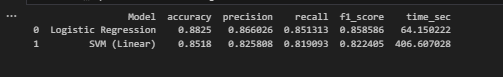

## Q2 ‚Äî Ensemble Models for Glasses Detection

1. Train a **Random Forest** classifier and a **Boosting-based** classifier (e.g., AdaBoost, Gradient Boosting, XGBoost, or LightGBM ‚Äî restricted to those covered in lectures) to predict whether the person in the image is **wearing glasses**.
2. Evaluate both models using a rigorous **cross-validation scheme** and present a comprehensive **error analysis**.
3. **Select and justify** the model you believe is better suited to the task, both in terms of accuracy, precision, recall, and computational considerations.

In [38]:
def extract_label_glasses(example):
    """0: G√∂zl√ºk yok, 1: G√∂zl√ºk var"""
    return int(example['attributes']['Eyeglasses'])

In [39]:
def get_dataset_arrays_2(dataset, n_samples=10000, image_size=(64, 64)):

    X_list = []
    y_list = []

    for i, example in enumerate(tfds.as_numpy(dataset)):
        if i >= n_samples:
            break
        x = preprocess_image(example, image_size=image_size)
        y = extract_label_glasses(example)
        X_list.append(x)
        y_list.append(y)

    return np.array(X_list), np.array(y_list)


In [ ]:
# 20.000 eƒüitim, 5.000 test √∂rneƒüi
X_train_glasses, y_train_glasses = get_dataset_arrays_2(train_ds, n_samples=15000, image_size=(64, 64))
X_test_glasses, y_test_glasses = get_dataset_arrays_2(test_ds, n_samples=4000, image_size=(64, 64))

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model listesi
models = [
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=42)),
    ("AdaBoost", AdaBoostClassifier(n_estimators=100, random_state=42)),
    ("XGBoost", XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ("LightGBM", LGBMClassifier(n_estimators=100, random_state=42))
]

# Sonu√ßlarƒ± tutmak i√ßin liste
ensemble_results = []

for name, model in models:
    print(f"üîç {name} modeli deƒüerlendiriliyor...")
    result = evaluate_model(model, X_train_glasses, y_train_glasses)
    result["Model"] = name
    ensemble_results.append(result)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



Size attƒ±ƒüƒ±m mailde belirttiƒüim durumdan dolayƒ± iki kodu aynƒ± anda √ßalƒ±≈ütƒ±rdƒ±m ve bu soruyu Google Colab √ºzerinde √ßalƒ±≈ütƒ±rdƒ±m. Kodum √ßalƒ±≈ütƒ±rdƒ±ƒüƒ±m kod ile tamamen aynƒ±dƒ±r. Sonu√ßlarƒ± a≈üaƒüƒ±da payla≈üƒ±yorum.




!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [ ]:
ensemble_df = pd.DataFrame(ensemble_results).sort_values("f1_score", ascending=False)
print(ensemble_df)

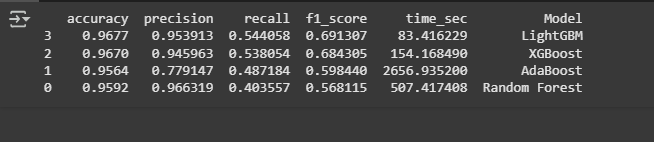

Bu g√∂revde ‚ÄúEyeglasses‚Äù etiketi kullanƒ±larak bir ki≈üinin g√∂zl√ºk takƒ±p takmadƒ±ƒüƒ±nƒ± tahmin etmek √ºzere d√∂rt farklƒ± ensemble model eƒüitildi: Random Forest, AdaBoost, XGBoost ve LightGBM. Bu d√∂rt modeli, √∂n i≈ülenmi≈ü veri seti √ºzerinde cross-validation kullanƒ±larak deƒüerlendirdim ve sonu√ßlar accuracy, precision, recall, f1-score ve hesaplama s√ºresi √ºzerinden kar≈üƒ±la≈ütƒ±rdƒ±m. Elde edilen metrikler, yalnƒ±zca doƒüruluƒüu deƒüil, aynƒ± zamanda modelin sƒ±nƒ±flandƒ±rmadaki davranƒ±≈ü bi√ßimini de yorumlayabilmemize olanak tanƒ±yor.

ƒ∞lk olarak doƒüruluk (accuracy) a√ßƒ±sƒ±ndan bakƒ±ldƒ±ƒüƒ±nda, en y√ºksek ba≈üarƒ± LightGBM (0.9677) tarafƒ±ndan elde edildi. Bunu sƒ±rasƒ±yla XGBoost (0.9670), Random Forest (0.9592) ve AdaBoost (0.9564) izliyor. Aralarƒ±ndaki fark k√º√ß√ºk g√∂r√ºnse de √∂zellikle f1-score ve recall gibi daha duyarlƒ± metriklere ge√ßildiƒüinde farklƒ±lƒ±klarƒ±n daha belirgin hale geldiƒüini g√∂r√ºyoruz.

Precision a√ßƒ±sƒ±ndan bakƒ±ldƒ±ƒüƒ±nda LightGBM (0.9539) ve Random Forest (0.9663) olduk√ßa y√ºksek deƒüerler veriyor. Bu da bu iki modelin ‚Äúg√∂zl√ºk takƒ±yor‚Äù dediƒüi √∂rneklerde hataya √ßok az yer verdiƒüini g√∂steriyor. Ancak burada dikkat edilmesi gereken konu, precision‚Äôƒ±n sadece pozitif sƒ±nƒ±f tahminlerinin doƒüruluƒüunu √∂l√ßt√ºƒü√ºd√ºr. Yani model az sayƒ±da √∂rneƒüe ‚Äúg√∂zl√ºk takƒ±yor‚Äù diyor olabilir, ama dediƒüi zaman b√ºy√ºk ihtimalle doƒüru √ßƒ±kƒ±yor. Bu, √∂zellikle azƒ±nlƒ±k sƒ±nƒ±fƒ± √ßok az sayƒ±da ise precision‚Äôƒ±n ≈üi≈üirilmi≈ü g√∂r√ºnmesine neden olabilir.

Recall metriklerine ge√ßtiƒüimizde ise tablo deƒüi≈üiyor. LightGBM burada da lider konumda (0.5440), fakat deƒüer yine de ideal bir seviyenin altƒ±nda. Random Forest ise recall a√ßƒ±sƒ±ndan olduk√ßa zayƒ±f (0.4035). Bu ≈üu anlama geliyor: Random Forest bir√ßok g√∂zl√ºkl√º ki≈üiyi g√∂zl√ºks√ºz olarak sƒ±nƒ±flandƒ±rmƒ±≈ü. Bu durum √∂zellikle hata derecesinin pozitif sƒ±nƒ±f √ºzerinde daha y√ºksek olduƒüu uygulamalarda problem yaratabilir. √ñrneƒüin, bir g√ºvenlik sisteminde g√∂zl√ºkl√º bireylerin √∂zel olarak tespit edilmesi gerekiyorsa, y√ºksek recall deƒüeri daha √∂nemli hale gelir.

Model kar≈üƒ±la≈ütƒ±rmasƒ±nda √∂zellikle F1-Score metriƒüi √∂nemli √ß√ºnk√º precision ve recall arasƒ±ndaki dengeyi √∂l√ß√ºyor. Bu a√ßƒ±dan LightGBM bir kez daha √∂ne √ßƒ±kƒ±yor (0.6913). XGBoost (0.6843) ile √ßok yakƒ±n bir performans g√∂stermi≈ü, bu da iki modelin benzer karar sƒ±nƒ±rlarƒ± √ßizebildiƒüini g√∂steriyor. AdaBoost (0.5984) ve Random Forest (0.5681) ise olduk√ßa geride kalmƒ±≈ü durumda.

Son olarak hesaplama s√ºresi (time_sec) a√ßƒ±sƒ±ndan kar≈üƒ±la≈ütƒ±rdƒ±ƒüƒ±mƒ±zda AdaBoost‚Äôun bariz ≈üekilde en uzun s√ºrede tamamlandƒ±ƒüƒ± (2656.9 saniye) ve bu nedenle pratik uygulamalarda dezavantajlƒ± olabileceƒüi g√∂r√ºl√ºyor. Buna kar≈üƒ±n LightGBM sadece 83.4 saniyede tamamlanarak en hƒ±zlƒ± √ßalƒ±≈üan model olmu≈ütur. Bu y√∂n√ºyle LightGBM hem en y√ºksek ba≈üarƒ±yƒ± veren hem de en az kaynak t√ºketen model olarak √∂ne √ßƒ±kmaktadƒ±r.

Genel Deƒüerlendirme:

Model tercihi uygulama amacƒ±na g√∂re deƒüi≈üebilir. Eƒüer amacƒ±mƒ±z pozitif sƒ±nƒ±flarƒ±n (yani g√∂zl√ºkl√º bireylerin) m√ºmk√ºn olduƒüunca eksiksiz tespiti ise, recall deƒüeri y√ºksek olan LightGBM ve XGBoost tercih edilmelidir. √ñte yandan kaynak t√ºketiminin minimize edilmesi gereken, ger√ßek zamanlƒ± sistemlerde LightGBM a√ßƒ±k ara en iyi tercih olacaktƒ±r. Random Forest modeli y√ºksek precision‚Äôƒ±na raƒümen d√º≈ü√ºk recall nedeniyle dengeli performans g√∂stermemi≈ütir. AdaBoost ise hesaplama s√ºresinin uzunluƒüu ve d√º≈ü√ºk genel ba≈üarƒ±mƒ± nedeniyle bu senaryo i√ßin uygun g√∂r√ºnmemektedir.

Sonu√ß olarak, bu g√∂rev √∂zelinde LightGBM modeli hem istatistiksel ba≈üarƒ± hem de hesaplama verimliliƒüi a√ßƒ±sƒ±ndan en uygun model olarak deƒüerlendirilebilir. Verinin dengeli olmamasƒ± (g√∂zl√ºkl√º ve g√∂zl√ºks√ºz) gibi durumlarda, bu t√ºr boosting tabanlƒ± modellerin daha ayƒ±rt edici karar sƒ±nƒ±rlarƒ± √ßizebilmesi √∂nemli bir avantajdƒ±r.

Bu veri setinde de veriyi tam olarak kullanamadƒ±ƒüƒ±mdan dolayƒ± net bir analiz yapamadƒ±m. Veri setim tam olsaydƒ± s√ºre orantƒ±sƒ± deƒüi≈ümese de bir model performans konusunda bariz √∂ne √ßƒ±kabilirdi.

## Q3 ‚Äî Neural Network Models for Smile Detection

1. Design and train **two distinct neural network architectures** for the task of predicting whether the person is **smiling**. Second model must have more hidden layer than the first one. You should explore different design choices, such as:
   - Convolutional and pooling layers
   - Activation functions (e.g., ReLU, tanh)
   - Use or omission of dropout, batch normalization, or skip connections
   - Loss functions (binary accuracy, binary cross-entropy etc.)
   - Choice of optimizers (ADAM, SGD etc.)
   - Learning rates.
2. Evaluate both models using a rigorous **cross-validation scheme** and present a comprehensive **error analysis**.
3. **Select and justify** the model you believe is better suited to the task, both in terms of accuracy, precision, recall, and computational considerations.

In [43]:
def extract_label_smile(example):
    """0: G√ºl√ºmsemiyor, 1: G√ºl√ºms√ºyor"""
    return int(example['attributes']['Smiling'].numpy())

In [44]:
X_smile_train, y_smile_train = get_dataset_arrays(train_ds, n_samples=10000, image_size=(64, 64))
X_smile_test, y_smile_test = get_dataset_arrays(test_ds, n_samples=2500, image_size=(64, 64))

In [45]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import tensorflow as tf

def evaluate_keras_model(build_fn, X, y, cv_folds=5, epochs=10, batch_size=64):
    """
    Keras modellerini cross-validation ile deƒüerlendirir.
    build_fn: Modeli in≈üa eden fonksiyon
    """
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    accs, precs, recalls, f1s = [], [], [], []
    start_time = time.time()

    for train_idx, val_idx in skf.split(X, y):
        model = build_fn()
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(X[train_idx], y[train_idx], 
                  epochs=epochs,
                  batch_size=batch_size,
                  verbose=0)

        y_pred_prob = model.predict(X[val_idx])
        y_pred = (y_pred_prob > 0.5).astype("int32")

        accs.append(accuracy_score(y[val_idx], y_pred))
        precs.append(precision_score(y[val_idx], y_pred))
        recalls.append(recall_score(y[val_idx], y_pred))
        f1s.append(f1_score(y[val_idx], y_pred))

    duration = time.time() - start_time

    return {
        'accuracy': np.mean(accs),
        'precision': np.mean(precs),
        'recall': np.mean(recalls),
        'f1_score': np.mean(f1s),
        'time_sec': duration
    }


In [46]:
def build_model_1():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(64*64,)),
        tf.keras.layers.Dense(128, activation='tanh'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [50]:
def build_model_2():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(64*64,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [54]:
def build_model_3():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(64, 64, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [57]:
def build_model_4():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(64, 64, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


In [ ]:
results_1 = evaluate_keras_model(build_model_1, X_smile_train, y_smile_train, epochs=10, batch_size=64)
results_1["Model"] = "Model 1 - Dense + tanh"

63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4ms/step


In [51]:
results_2 = evaluate_keras_model(build_model_2, X_smile_train, y_smile_train, epochs=10, batch_size=64)
results_2["Model"] = "Model 2 - Dense + ReLU + Dropout"

63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 3ms/step
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 4ms/step


In [60]:
def preprocess_image_cnn(example, image_size=(64, 64)):
    """CNN i√ßin: grayscale, yeniden boyutlandƒ±rma, normalize, orijinal shape (64,64,1) korunur"""
    image = tf.image.rgb_to_grayscale(example['image'])
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image.numpy()

In [ ]:
def get_dataset_arrays(dataset, n_samples=None, image_size=(64, 64), flatten=True):
    X_list = []
    y_list = []

    for i, example in enumerate(tfds.as_numpy(dataset)):
        if n_samples is not None and i >= n_samples:
            break

        image = tf.image.rgb_to_grayscale(example['image'])
        image = tf.image.resize(image, image_size)

        if flatten:
            image = tf.reshape(image, [-1])  # (4096,)
        else:
            image = tf.cast(image, tf.float32)  # (64, 64, 1)

        image = image / 255.0

        label = int(example['attributes']['Smiling'])
        X_list.append(image.numpy())
        y_list.append(label)

    return np.array(X_list), np.array(y_list)


In [ ]:
X_smile_train_cnn, y_smile_train = get_dataset_arrays(train_ds, n_samples=10000, image_size=(64, 64), flatten=False)

In [63]:
results_3 = evaluate_keras_model(build_model_3, X_smile_train_cnn, y_smile_train, epochs=10, batch_size=64)
results_3["Model"] = "Model 3 - Conv2D + Pool + Dense"

63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 11ms/step
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 8ms/step
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 7ms/step
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 8ms/step
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 8ms/step


In [64]:
results_4 = evaluate_keras_model(build_model_4, X_smile_train_cnn, y_smile_train, epochs=10, batch_size=64)
results_4["Model"] = "Model 4 - CNN + BatchNorm + Dropout"

63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 21ms/step
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 21ms/step
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 20ms/step
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 19ms/step
63/63 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 19ms/step


In [65]:
for i, r in enumerate([results_1, results_2, results_3, results_4], 1):
    print(f"Model {i} Sonu√ßlarƒ±:")
    for k, v in r.items():
        print(f"  {k}: {v}")
    print("\n" + "-"*40)


Model 1 Sonu√ßlarƒ±:
  accuracy: 0.8760999999999999
  precision: 0.8874113551741605
  recall: 0.8088305489260144
  f1_score: 0.844505026683261
  time_sec: 47.009406328201294
  Model: Model 1 - Dense + tanh

----------------------------------------
Model 2 Sonu√ßlarƒ±:
  accuracy: 0.8390000000000001
  precision: 0.8869780880839679
  recall: 0.713365155131265
  f1_score: 0.7855877378894633
  time_sec: 82.52642965316772
  Model: Model 2 - Dense + ReLU + Dropout

----------------------------------------
Model 3 Sonu√ßlarƒ±:
  accuracy: 0.885
  precision: 0.8852563119683298
  recall: 0.876091476091476
  f1_score: 0.87969814929076
  time_sec: 314.58634305000305
  Model: Model 3 - Conv2D + Pool + Dense

----------------------------------------
Model 4 Sonu√ßlarƒ±:
  accuracy: 0.8783999999999998
  precision: 0.9097523639529506
  recall: 0.834095634095634
  f1_score: 0.8674977404434687
  time_sec: 1365.425379037857
  Model: Model 4 - CNN + BatchNorm + Dropout

----------------------------------

Normalde 4 tane daha sinir aƒüƒ± modeli uygulayacaktƒ±m ancak yeti≈ümediƒüi i√ßin uygulayamadƒ±m. 

Bu √∂devde, ki≈üilerin g√ºl√ºmseyip g√ºl√ºmsemediƒüini sƒ±nƒ±flandƒ±rmak i√ßin d√∂rt farklƒ± yapay sinir aƒüƒ± modeli eƒüitildi. Modeller iki grupta deƒüerlendirilebilir: klasik tam baƒülantƒ±lƒ± (dense) modeller (Model 1 ve Model 2) ve konvol√ºsyonel sinir aƒüƒ± (CNN) tabanlƒ± modeller (Model 3 ve Model 4). Her bir model 10 epoch boyunca eƒüitim aldƒ± ve 5-fold stratified cross-validation ile deƒüerlendirildi. Sonu√ßlar accuracy, precision, recall, f1-score ve eƒüitim s√ºresi gibi kriterlerle kar≈üƒ±la≈ütƒ±rƒ±ldƒ±.

Model 1 ‚Äì Dense + tanh:
En basit yapƒ±ya sahip bu modelde yalnƒ±zca bir gizli katman ve tanh aktivasyonu kullanƒ±ldƒ±. 0.8761 doƒüruluk ve 0.8445 F1 skoru ile temel d√ºzeyde iyi bir performans g√∂sterdi. ƒ∞lgin√ß bir ≈üekilde precision (0.8874) ve recall (0.8088) arasƒ±nda dengeli bir ili≈üki kurmayƒ± ba≈üardƒ±. Modelin olduk√ßa hƒ±zlƒ± eƒüitilmesi (47 saniye) de pratikte √∂nemli bir avantaj. Basit ama etkili olmasƒ±, boyutu az olan sistemlerde kullanƒ±labilirliƒüini artƒ±rƒ±yor.

Model 2 ‚Äì Dense + ReLU + Dropout:
Bu modelde aktivasyon fonksiyonu ReLU olarak deƒüi≈ütirildi ve d√ºzenleme amacƒ±yla Dropout eklendi. Ancak beklentinin aksine bu yapƒ± Model 1‚Äôe g√∂re daha d√º≈ü√ºk performans verdi: accuracy 0.8390 ve F1 skoru 0.7856‚Äôya geriledi. Recall deƒüerinde de d√º≈ü√º≈ü (0.7134) g√∂zlemledim. Buradaki performans kaybƒ±, dropout oranƒ±nƒ±n veya katman geni≈üliƒüinin optimal olmamasƒ±ndan kaynaklanƒ±yor olabilir. Ayrƒ±ca modelin eƒüitim s√ºresi yakla≈üƒ±k iki katƒ±na √ßƒ±kmasƒ±na raƒümen saƒüladƒ±ƒüƒ± katkƒ± yetersiz kalmƒ±≈ütƒ±r. Bu da her karma≈üƒ±klƒ±k artƒ±≈üƒ±nƒ±n daha iyi sonu√ßlar getirmediƒüini g√∂steriyor.

Model 3 ‚Äì Conv2D + Pooling + Dense:
ƒ∞lk CNN tabanlƒ± model olan bu yapƒ±da, Conv2D ve MaxPooling katmanlarƒ± ile g√∂rsel verideki mek√¢nsal ili≈ükiler √∂ƒürenildi. Bu model 0.885 doƒüruluk, 0.8797 F1 skoru ve 0.8761 recall deƒüeri ile en iyi genel ba≈üarƒ±yƒ± g√∂steren model oldu. √ñzellikle recall deƒüerinin y√ºksek olmasƒ±, g√ºl√ºmseyen ki≈üilerin doƒüru ≈üekilde tanƒ±nmasƒ±nda etkili olduƒüunu g√∂steriyor. Eƒüitim s√ºresi √∂nceki modellere g√∂re ciddi ≈üekilde arttƒ± (yakla≈üƒ±k 5 dakikaya yakƒ±n), ancak bu performans kar≈üƒ±lƒ±ƒüƒ±nda makul bir bedel. G√∂rsel verilerde uzamsal filtreleme gibi tekniklerin etkisi burada √ßok net g√∂r√ºl√ºyor.

Model 4 ‚Äì CNN + BatchNorm + Dropout:
Bu modelde Model 3‚Äô√ºn √ºzerine BatchNormalization ve Dropout katmanlarƒ± eklenerek derinlik ve d√ºzenleme artƒ±rƒ±ldƒ±. Doƒüruluk (0.8784) ve F1 skoru (0.8675) Model 3 kadar y√ºksek olmasa da, precision (0.9098) deƒüeri ile en doƒüru pozitif sƒ±nƒ±flamayƒ± bu model ger√ßekle≈ütirdi. Bu durum modelin daha se√ßici davrandƒ±ƒüƒ±nƒ± ve yalnƒ±zca ger√ßekten emin olduƒüu zaman ‚Äúg√ºl√ºms√ºyor‚Äù sƒ±nƒ±fƒ±nƒ± verdiƒüini g√∂steriyor. Ancak eƒüitim s√ºresi olduk√ßa uzundu (1365 saniye ‚âà 22 dakika), bu da ger√ßek zamanlƒ± uygulamalarda dezavantaj olu≈üturabilir. Performans-maliyet dengesinde Model 3 kadar verimli olmadƒ±ƒüƒ± s√∂ylenebilir.

Bu tabloya bakƒ±ldƒ±ƒüƒ±nda Model 3, en iyi F1 skorunu ve recall deƒüerini saƒülayarak genel anlamda en dengeli ve ba≈üarƒ±lƒ± model olarak √∂ne √ßƒ±kƒ±yor. Eƒüitim s√ºresi makul d√ºzeyde ve performans a√ßƒ±sƒ±ndan tatmin edici. Model 4, precision a√ßƒ±sƒ±ndan lider olsa da √ßok daha uzun s√ºrede eƒüitildiƒüinden her senaryoda tercih edilemeyebilir. Model 1, hƒ±zlƒ± ve hafif yapƒ±sƒ±yla baseline olarak g√º√ßl√º dururken, Model 2 ise ekstra karma≈üƒ±klƒ±ƒüƒ±n her zaman daha iyi sonu√ßlar doƒüurmayacaƒüƒ±nƒ± a√ßƒ±k√ßa g√∂steriyor.

Sonu√ß olarak, bu g√∂rev i√ßin Model 3 (CNN tabanlƒ± mimari), hem y√ºksek ba≈üarƒ± oranƒ± hem de hesaplama a√ßƒ±sƒ±ndan dengeli yapƒ±sƒ±yla en uygun se√ßim olarak deƒüerlendirilmektedir. CNN mimarileri g√∂rsel verilerdeki mek√¢nsal ili≈ükileri daha iyi √∂ƒürenebildiƒüi i√ßin, √∂zellikle y√ºz ifadeleri gibi detaylƒ± analizlerde klasik dense yapƒ±lara kƒ±yasla belirgin avantaj sunmaktadƒ±r.

## Q4 ‚Äî Reflective Report

Write a structured qualitative report reflecting on your process, design decisions, and implementation.

Address the following questions in your narrative:

- What were the main challenges you encountered, and how did you overcome them?
- Which part of the process (e.g., data handling, model implementation, debugging) consumed the most time and effort?
- Which class of models ‚Äî linear (SVM vs logistic regression), ensemble (random forests vs boosting), or neural networks ‚Äî did you find most **intuitive to implement**, most **computationally efficient**, and most **effective** in terms of performance?
- In designing the neural network models, I expect you to do a lot of experimentation. I don't expect you to document the whole list of different choices you made. A section of your report must include a detailed analysis of your experiments with the neural network models.
   + Which neural network framework did you choose, and why?
   + How did increasing the number of layers affect the results?
   + How did you make your choices of layers, activation functions, number of neurons, loss functions, optimizers, learning rates? 

Model uygulamasƒ± ve hata ayƒ±klama a≈üamasƒ± benim i√ßin √ßok zor oldu √ß√ºnk√º √ßok uzun s√ºrd√º. 

Benim en efektif bulduƒüum LightGBM algoritmasƒ± oldu. Modelleri tam veri setiyle √ßalƒ±≈üamadƒ±ƒüƒ±m i√ßin tam olarak deƒüerlendiremedim ancak kullanabildiƒüim kadarƒ±yla LightGBM algoritmasƒ± zaman ve performans a√ßƒ±sƒ±ndan bence en verimlisiydi.

Model 3 benim i√ßin en efektifi √ß√ºnk√º hem doƒüruluk oranƒ± y√ºksek hem de zaman a√ßƒ±sƒ±ndan optimize bir model.